# Data preparation and exploration

## Setup and imports

In [15]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
else:
  PROJECT_ROOT = '../'

In [ ]:
%pip install -q tableone

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tableone import TableOne

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

## Data import

In [17]:
heart_disease = pd.read_csv(f'{PROJECT_ROOT}/data/heart_disease_cleveland_hungary.csv')

# Remove duplicates and null values, as per Straw et al.

rows_to_drop  = (heart_disease['ST slope'] == 0) | (heart_disease['cholesterol'] == 0) | (heart_disease['resting bp s'] == 0) | (heart_disease.duplicated(keep='first'))
heart_disease.drop(heart_disease[rows_to_drop].index, inplace=True)

# Clip negative values of st (oldpeak)
heart_disease['oldpeak'] = heart_disease['oldpeak'].clip(lower=0)

print(heart_disease.describe())

              age         sex  chest pain type  resting bp s  cholesterol  \
count  745.000000  745.000000       745.000000    745.000000   745.000000   
mean    52.861745    0.755705         3.163758    133.000000   244.702013   
std      9.496091    0.429957         0.956037     17.283142    59.165249   
min     28.000000    0.000000         1.000000     92.000000    85.000000   
25%     46.000000    1.000000         2.000000    120.000000   208.000000   
50%     54.000000    1.000000         3.000000    130.000000   237.000000   
75%     59.000000    1.000000         4.000000    140.000000   275.000000   
max     77.000000    1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count           745.000000   745.000000      745.000000       745.000000   
mean              0.166443     0.640268      140.237584         0.385235   
std               0.372728     0.838900       24.538727         0.486978   
mi

## Study population summary

In [18]:
from tableone import TableOne

# Descriptive statistics
table1 = TableOne(heart_disease,
                  groupby='sex',
                  continuous=['age','cholesterol','max heart rate','resting bp s','oldpeak'],
                  categorical=['target','chest pain type', 'fasting blood sugar','resting ecg','exercise angina','ST slope'],
                  missing=False
                  )

print(table1)

                             Grouped by sex                            
                                    Overall             0             1
n                                       745           182           563
age, mean (SD)                   52.9 (9.5)    52.2 (9.3)    53.1 (9.5)
chest pain type, n (%)     1       41 (5.5)       9 (4.9)      32 (5.7)
                           2     166 (22.3)     59 (32.4)    107 (19.0)
                           3     168 (22.6)     52 (28.6)    116 (20.6)
                           4     370 (49.7)     62 (34.1)    308 (54.7)
resting bp s, mean (SD)        133.0 (17.3)  132.0 (18.6)  133.3 (16.8)
cholesterol, mean (SD)         244.7 (59.2)  255.8 (62.9)  241.1 (57.5)
fasting blood sugar, n (%) 0     621 (83.4)    163 (89.6)    458 (81.3)
                           1     124 (16.6)     19 (10.4)    105 (18.7)
resting ecg, n (%)         0     444 (59.6)    109 (59.9)    335 (59.5)
                           1     125 (16.8)     26 (14.3)     99

In [19]:

heart_disease.rename(columns={'sex':'sex', 'chest pain type':'cp', 'resting bp s':'bp', 'cholesterol':'chol',
                              'fasting blood sugar':'fbs', 'resting ecg':'ecg', 'max heart rate':'mhr', 'exercise angina':'ang',
                              'oldpeak':'st', 'ST slope':'slope', 'target':'cvd'}, inplace=True)



## Data exploration

### Distributions

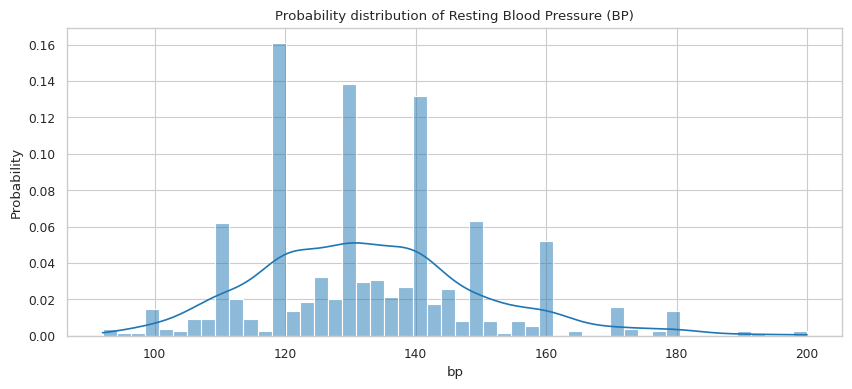

In [20]:
# BP distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='bp', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Resting Blood Pressure (BP)')
plt.show()

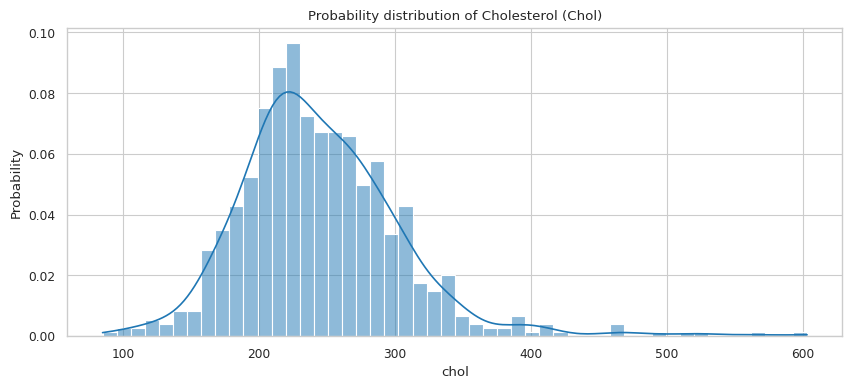

In [21]:
# Chol distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='chol', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Cholesterol (Chol)')
plt.show()

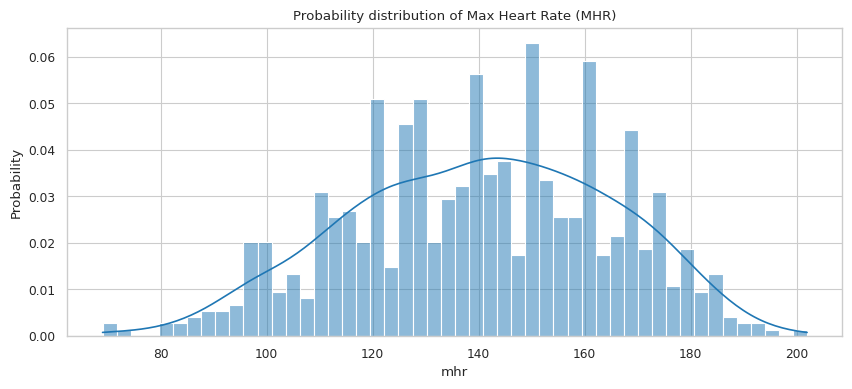

In [22]:
# MHR distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='mhr', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Max Heart Rate (MHR)')
plt.show()

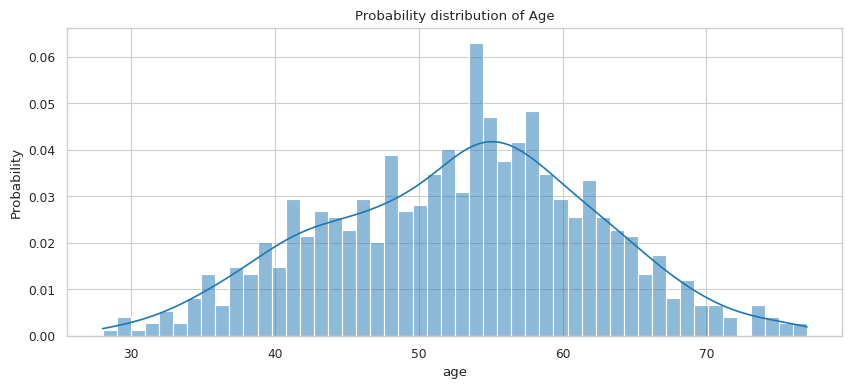

In [23]:
# Age distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='age', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Age')
plt.show()

### Stratified distributions

In [24]:
def format_mean_std(col):
  return f'{col.mean():.2f} ± {col.std():.2f}'

def format_median(col):
  return f'{col.median():.2f}'

def stratified_stats(df, var):
  df = heart_disease.pivot_table(index=['cvd','sex'],
                                 values=var, aggfunc=[format_mean_std, format_median])
  df.columns = df.columns.droplevel()
  df.columns = ['Mean +- Std', 'Median']
  return df

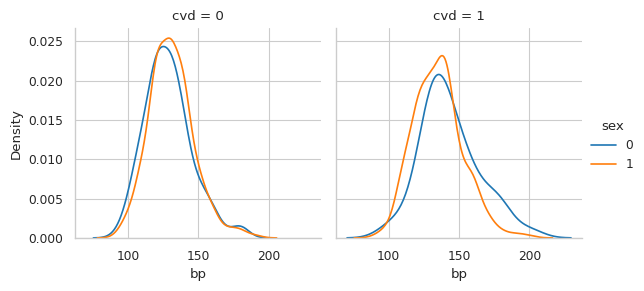



            Mean +- Std  Median
cvd sex                        
0   0    128.77 ± 16.69  130.00
    1    130.96 ± 15.79  130.00
1   0    143.38 ± 20.66  139.00
    1    135.19 ± 17.42  135.00


In [25]:
g = sns.FacetGrid(heart_disease, col="cvd", hue='sex')
g.map(sns.kdeplot, 'bp')
g.add_legend()
plt.show()

print('\n')
print(stratified_stats(heart_disease, 'bp'))

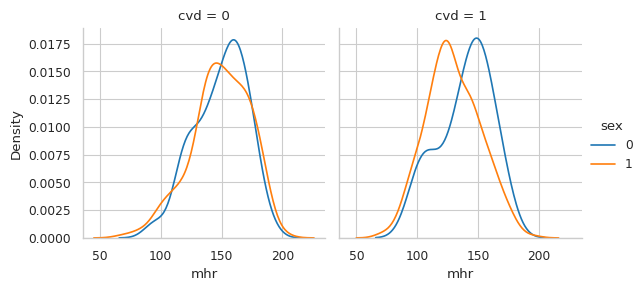



            Mean +- Std  Median
cvd sex                        
0   0    149.18 ± 21.61  152.00
    1    148.99 ± 23.97  150.00
1   0    139.25 ± 21.70  144.00
    1    129.44 ± 22.20  127.00


In [26]:
g = sns.FacetGrid(heart_disease, col="cvd", hue='sex')
g.map(sns.kdeplot, 'mhr')
g.add_legend()
plt.show()

print('\n')
print(stratified_stats(heart_disease, 'mhr'))

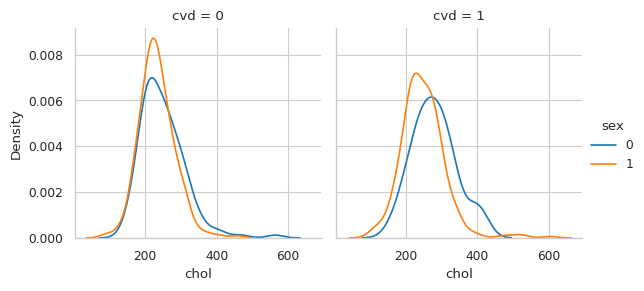



            Mean +- Std  Median
cvd sex                        
0   0    249.18 ± 62.23  238.50
    1    232.81 ± 50.24  227.00
1   0    279.18 ± 60.11  275.00
    1    247.67 ± 61.97  243.00


In [27]:
g = sns.FacetGrid(heart_disease, col="cvd", hue='sex')
g.map(sns.kdeplot, 'chol')
g.add_legend()
plt.show()

print('\n')
print(stratified_stats(heart_disease, 'chol'))

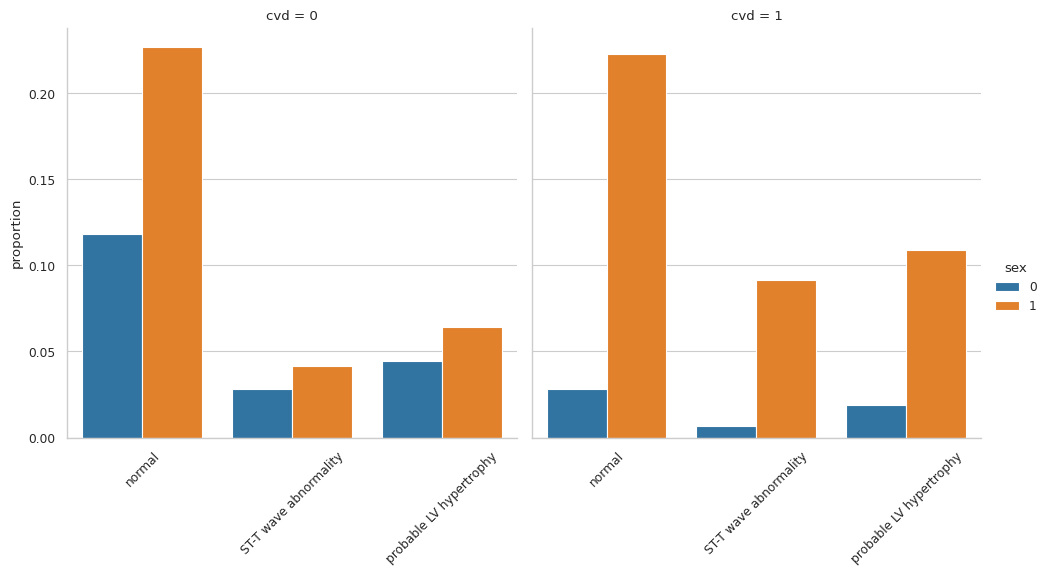

In [28]:
g = sns.catplot(data=heart_disease, x='ecg', col='cvd', kind='count', stat='proportion', hue='sex')
g.set_xticklabels(['normal','ST-T wave abnormality','probable LV hypertrophy'], rotation=45)
g.set_xlabels('')
plt.show()

## Pre-processing

In [29]:
heart_disease_processed = heart_disease.copy()

# Z-score for age and mhr
cont_variables = ['mhr', 'age']
for var in cont_variables:
  heart_disease_processed[var] = (heart_disease_processed[var] - heart_disease_processed[var].mean()) / heart_disease_processed[var].std()

# Log and scaling for BP
log_chol = np.log(heart_disease_processed['chol'])
heart_disease_processed['chol'] = (log_chol - log_chol.mean()) / log_chol.std()

# Log and scaling for BP
log_bp = np.log(heart_disease_processed['bp'])
heart_disease_processed['bp'] = (log_bp - log_bp.mean()) / log_bp.std()

# Indexing cp and slope at 0
heart_disease_processed['cp'] = heart_disease_processed['cp'] - 1
heart_disease_processed['slope'] = heart_disease_processed['slope'] - 1

heart_disease_processed.reset_index(drop=True, inplace=True)

print(heart_disease_processed.head())

heart_disease_processed.to_csv(f'{PROJECT_ROOT}/data/heart_disease_cleaned.csv', index=False)

        age  sex  cp        bp      chol  fbs  ecg       mhr  ang   st  slope  \
0 -1.354425    1   1  0.466063  0.825012    0    0  1.294379    0  0.0      0   
1 -0.406667    0   2  1.511938 -1.188684    0    0  0.642349    0  1.0      1   
2 -1.670345    1   1 -0.114382  0.735784    0    1 -1.721262    0  0.0      0   
3 -0.511973    0   3  0.353365 -0.452823    0    0 -1.313743    1  1.5      1   
4  0.119866    1   2  1.006445 -0.848258    0    0 -0.743216    0  0.0      0   

   cvd  
0    0  
1    1  
2    0  
3    1  
4    0  
